In [ ]:
import os
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms.community import greedy_modularity_communities, label_propagation_communities, modularity
from collections import Counter, defaultdict, Counter
from scipy.stats import pearsonr, spearmanr, kendalltau, poisson, expon
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial
import powerlaw


recipes_graph = nx.read_gml("final_recipe_graph_min_common_6.gml")

In [26]:
for node in recipes_graph.nodes(data=True):
    print(node)


('137739', {'name': 'arriba   baked winter squash mexican style', 'num_ingredients': 7, 'ingredients': ['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil', 'salt']})
('31490', {'name': 'a bit different  breakfast pizza', 'num_ingredients': 6, 'ingredients': ['prepared pizza crust', 'sausage patty', 'eggs', 'milk', 'salt and pepper', 'cheese']})
('112140', {'name': 'all in the kitchen  chili', 'num_ingredients': 13, 'ingredients': ['ground beef', 'yellow onions', 'diced tomatoes', 'tomato paste', 'tomato soup', 'rotel tomatoes', 'kidney beans', 'water', 'chili powder', 'ground cumin', 'salt', 'lettuce', 'cheddar cheese']})
('59389', {'name': 'alouette  potatoes', 'num_ingredients': 11, 'ingredients': ['spreadable cheese with garlic and herbs', 'new potatoes', 'shallots', 'parsley', 'tarragon', 'olive oil', 'red wine vinegar', 'salt', 'pepper', 'red bell pepper', 'yellow bell pepper']})
('44061', {'name': 'amish  tomato ketchup  for canning', 'num_ingredi

## Do recipes from the same cuisine form distinct communities within the graph?


In [27]:
def randomize_graph(graph):
    randomized_graph = nx.algorithms.smallworld.random_reference(graph, connectivity=False)
    return randomized_graph

In [ ]:
def print_total_communities_and_modularity(G, method, communities):
    total_communities = len(communities)
    modularity_value = modularity(G, communities)
    print(f"{method} - Total Communities: {total_communities}, Modularity: {modularity_value:.4f}")

def communities_greedy_label_summary(G, dataset_name):
    greedy_communities = list(greedy_modularity_communities(G))
    print_total_communities_and_modularity(G, "Greedy Modularity", greedy_communities)

    label_communities = list(label_propagation_communities(G))
    print_total_communities_and_modularity(G, "Label Propagation", label_communities)

print("\n=== Greedy and Label ===")
communities_greedy_label_summary(recipes_graph, 'Graph 6 Common Ingredients')

print("\n=== Randomized ===")
recipes_randomized = randomize_graph(recipes_graph)
communities_greedy_label_summary(recipes_randomized, 'Graph 6 Common Ingredients Randomized')


=== Greedy and Label ===
Greedy Modularity - Total Communities: 51, Modularity: 0.2571
Label Propagation - Total Communities: 49, Modularity: 0.0008

=== Randomized ===
Greedy Modularity - Total Communities: 49, Modularity: 0.0616
Label Propagation - Total Communities: 45, Modularity: 0.0000


In [29]:
def print_communities_by_name(G, method, communities):
    print(f"\n{method}:")
    for i, community in enumerate(communities):
        node_names = [G.nodes[node]['name'] for node in community]
        print(f"\nCommunity {i+1} ({len(node_names)} recipes):")
        for idx, name in enumerate(node_names, start=1):
            print(f"  {idx}. {name}")
    print(f"\nTotal number of communities: {len(communities)}")
    print(f"Modularity: {modularity(G, communities):.4f}")

def communities_greedy_label(G, dataset_name):
    greedy_communities = list(greedy_modularity_communities(G))
    print_communities_by_name(G, "Greedy Modularity", greedy_communities)

    label_communities = list(label_propagation_communities(G))
    print_communities_by_name(G, "Label Propagation", label_communities)

In [ ]:
communities_greedy_label(recipes_graph, 'Graph 6 Common Ingredients')


Greedy Modularity:

Community 1 (247 recipes):
  1. jiffy  roasted corn and jalapeno cornbread
  2. cheesy  vegan lasagna
  3. pour over anything  mushroom gravy
  4. leftovers  spaghetti sauce
  5. killer  lasagna
  6. make that chicken dance  salsa pasta
  7. geebee special  sandwiches
  8. chef salad  dressing
  9. old ladies on a bus    chicken
  10. janie marzetti
  11. california roll   salad
  12. homemade  vegetable soup from a can
  13. grilled  venison burgers
  14. george s at the cove  black bean soup
  15. extraordinary  macaroni and cheese
  16. go bears   party ryes
  17. dorito  popcorn seasoning
  18. buckley s  cajun salmon pasta
  19. no fettuccine  spaghetti alfredo
  20. fried  bacon in the oven
  21. posh   pork roast   crockpot
  22. rter med flsk   pea soup with pork
  23. mamma mia  ravioli bites
  24. hibachi  style salad dressing
  25. 1 asian noodle salad
  26. cream   of pumpkin or squash soup  vegan
  27. the mooch     zucchini sandwich
  28. berinzila   

## Which ingredients act as ”bridges” between different cuisines?

In [31]:

def analyze_communities(G, communities):
    analysis_results = []

    for i, community in enumerate(communities):
        recipe_names = [G.nodes[node]['name'] for node in community]

        all_ingredients = []
        for node in community:
            all_ingredients.extend(G.nodes[node].get('ingredients', []))

        ingredient_counts = Counter(all_ingredients)
        most_common_ingredients = ingredient_counts.most_common(10) 

        avg_num_ingredients = np.mean([G.nodes[node]['num_ingredients'] for node in community])

        analysis_results.append({
            "community": i + 1,
            "num_recipes": len(community),
            "most_common_ingredients": most_common_ingredients,
            "avg_num_ingredients": avg_num_ingredients,
            "recipe_names": recipe_names
        })

    return analysis_results


def print_community_analysis(results):
    for result in results:
        print("=" * 50)
        print(f"Community {result['community']}")
        print(f"Number of Recipes: {result['num_recipes']}")
        print(f"Average Number of Ingredients: {result['avg_num_ingredients']:.2f}")
        print("\nMost Common Ingredients:")
        for ingredient, count in result['most_common_ingredients']:
            print(f"  - {ingredient} ({count} times)")

        print("\nFirst 20 Recipes:")
        for idx, name in enumerate(result['recipe_names'][:20], start=1):
            print(f"  {idx}. {name}")
        print("=" * 50)



In [32]:
def find_bridge_ingredients(G, communities):
    node_to_community = {}
    for i, community in enumerate(communities):
        for node in community:
            node_to_community[node] = i

    bridge_ingredients = []
    for u, v in G.edges():
        if node_to_community[u] != node_to_community[v]:
            ingredients_u = set(G.nodes[u].get('ingredients', []))
            ingredients_v = set(G.nodes[v].get('ingredients', []))
            common_ingredients = ingredients_u.intersection(ingredients_v)
            bridge_ingredients.extend(common_ingredients)

    ingredient_counts = Counter(bridge_ingredients)

    return ingredient_counts

In [33]:


def find_bridge_ingredients_with_details(G, communities):
    node_to_community = {}
    for i, community in enumerate(communities):
        for node in community:
            node_to_community[node] = i + 1  

    bridge_ingredient_details = defaultdict(list)

    for u, v in G.edges():
        community_u = node_to_community[u]
        community_v = node_to_community[v]
        if community_u != community_v:
            ingredients_u = set(G.nodes[u].get('ingredients', []))
            ingredients_v = set(G.nodes[v].get('ingredients', []))
            common_ingredients = ingredients_u.intersection(ingredients_v)
            for ingredient in common_ingredients:
                bridge_ingredient_details[ingredient].append({
                    "recipe_u": G.nodes[u]['name'],
                    "community_u": community_u,
                    "recipe_v": G.nodes[v]['name'],
                    "community_v": community_v
                })

    return bridge_ingredient_details


In [34]:
greedy_communities = list(greedy_modularity_communities(recipes_graph))
community_analysis_results = analyze_communities(recipes_graph, greedy_communities)
print_community_analysis(community_analysis_results)

Community 1
Number of Recipes: 247
Average Number of Ingredients: 10.29

Most Common Ingredients:
  - salt (95 times)
  - onion (84 times)
  - pepper (51 times)
  - olive oil (45 times)
  - garlic cloves (39 times)
  - water (36 times)
  - garlic powder (35 times)
  - butter (29 times)
  - black pepper (25 times)
  - garlic (25 times)

First 20 Recipes:
  1. jiffy  roasted corn and jalapeno cornbread
  2. cheesy  vegan lasagna
  3. pour over anything  mushroom gravy
  4. leftovers  spaghetti sauce
  5. killer  lasagna
  6. make that chicken dance  salsa pasta
  7. geebee special  sandwiches
  8. chef salad  dressing
  9. old ladies on a bus    chicken
  10. janie marzetti
  11. california roll   salad
  12. homemade  vegetable soup from a can
  13. grilled  venison burgers
  14. george s at the cove  black bean soup
  15. extraordinary  macaroni and cheese
  16. go bears   party ryes
  17. dorito  popcorn seasoning
  18. buckley s  cajun salmon pasta
  19. no fettuccine  spaghetti alfr

In [35]:
bridge_ingredient_counts = find_bridge_ingredients(recipes_graph, greedy_communities)

print(f"{'Rank':<5} {'Ingredient':<25} {'Number of Connections'}")
print("=" * 50)
for rank, (ingredient, count) in enumerate(bridge_ingredient_counts.most_common(), start=1):
    print(f"{rank:<5} {ingredient:<25} {count}")

Rank  Ingredient                Number of Connections
1     salt                      2437
2     butter                    869
3     water                     561
4     flour                     491
5     milk                      487
6     sugar                     466
7     eggs                      370
8     pepper                    312
9     brown sugar               206
10    onion                     140
11    egg                       138
12    all-purpose flour         120
13    vegetable oil             116
14    lemon juice               86
15    sour cream                71
16    salt and pepper           69
17    cinnamon                  65
18    oil                       64
19    onions                    62
20    cheddar cheese            58
21    parmesan cheese           58
22    cream cheese              47
23    garlic cloves             46
24    celery                    42
25    paprika                   37
26    baking powder             37
27    olive oil       

In [36]:
bridge_ingredient_details = find_bridge_ingredients_with_details(recipes_graph, greedy_communities)

print("=" * 120)
print(f"{'Ingredient':<20} {'Recipe 1 (Community)':<45} {'Recipe 2 (Community)':<45}")
print("=" * 120)

for ingredient, connections in bridge_ingredient_details.items():
    print(f"\nIngredient: {ingredient}")
    for connection in connections[:10]: 
        print(f"  - {connection['recipe_u']} (Community {connection['community_u']}) "
              f"<-> {connection['recipe_v']} (Community {connection['community_v']})")
    print("-" * 120)

Ingredient           Recipe 1 (Community)                          Recipe 2 (Community)                         

Ingredient: olive oil
  - arriba   baked winter squash mexican style (Community 2) <-> alouette  potatoes (Community 1)
  - arriba   baked winter squash mexican style (Community 2) <-> cream  of spinach soup  vegan (Community 1)
  - arriba   baked winter squash mexican style (Community 2) <-> pick me up  party chicken kabobs (Community 1)
  - arriba   baked winter squash mexican style (Community 2) <-> real  italian bolognese sauce (Community 1)
  - arriba   baked winter squash mexican style (Community 2) <-> 1 french onion soup (Community 1)
  - arriba   baked winter squash mexican style (Community 2) <-> 10 can spaghetti sauce   oamc (Community 1)
  - arriba   baked winter squash mexican style (Community 2) <-> flipped  roast turkey (Community 1)
  - arriba   baked winter squash mexican style (Community 2) <-> from the field  green beans  fresh herbs and walnuts (Communit

## What are the most versatile or influential recipes based on their graph connectivity?

In [37]:
def compute_centralities(graph):
    degree_centrality = nx.degree_centrality(graph)
    betweenness_centrality = nx.betweenness_centrality(graph)
    closeness_centrality = nx.closeness_centrality(graph)
    eigenvector_centrality = nx.eigenvector_centrality(graph)
    
    return {
        'degree': degree_centrality,
        'betweenness': betweenness_centrality,
        'closeness': closeness_centrality,
        'eigenvector': eigenvector_centrality
    }

def get_top_recipes(graph, centralities, centrality_type='degree', top_n=10):
    if centrality_type not in centralities:
        raise ValueError("Invalid centrality type. Choose from ['degree', 'betweenness', 'closeness', 'eigenvector']")
    
    sorted_centralities = sorted(centralities[centrality_type].items(), key=lambda x: x[1], reverse=True)
    sorted_centralities = [(graph.nodes[node]['name'], centrality) for node, centrality in sorted_centralities]
    return sorted_centralities[:top_n] 



def get_top_recipes_by_frequency(graph, centralities, top_n=5):
    all_top_recipes = []
    
    for centrality_type in ['degree', 'betweenness', 'closeness', 'eigenvector']:
        top_recipes = get_top_recipes(graph, centralities, centrality_type=centrality_type, top_n=top_n)
        all_top_recipes.extend([recipe[0] for recipe in top_recipes]) 
    
    recipe_counts = Counter(all_top_recipes)
    
    top_recipes_by_frequency = recipe_counts.most_common(top_n)
    
    return top_recipes_by_frequency

In [38]:
def centralities_info(graph, graph_name):
    
    centralities = compute_centralities(graph)
    print(f"Centralities for {graph_name}: {centralities}")

    top_recipes_by_frequency = get_top_recipes_by_frequency(graph, centralities, top_n=5)
    print(f"Top Recipes by Frequency across Centralities in {graph_name}:")
    for recipe, count in top_recipes_by_frequency:
        print(f"{recipe}: {count} times")
    

In [ ]:
centralities_info(recipes_graph, "Recipe network with min. 6 common ingredients")

Centralities for Recipe network with min. 3 common ingredients: {'degree': {'137739': 0.13827655310621242, '31490': 0.06412825651302605, '112140': 0.1503006012024048, '59389': 0.14629258517034066, '44061': 0.18837675350701402, '5289': 0.002004008016032064, '25274': 0.01002004008016032, '67888': 0.22044088176352702, '70971': 0.002004008016032064, '75452': 0.1903807615230461, '109439': 0.0, '42198': 0.09819639278557113, '67547': 0.2545090180360721, '107517': 0.05611222444889779, '39959': 0.0, '63986': 0.1442885771543086, '43026': 0.0060120240480961915, '23933': 0.0, '8559': 0.05410821643286573, '23850': 0.1062124248496994, '76808': 0.10821643286573146, '24701': 0.16633266533066132, '83873': 0.0721442885771543, '107699': 0.30260521042084165, '49262': 0.11222444889779558, '48156': 0.0060120240480961915, '54272': 0.17434869739478956, '47366': 0.19639278557114226, '37073': 0.0, '44123': 0.1222444889779559, '27087': 0.2685370741482966, '59952': 0.19639278557114226, '93249': 0.0040080160320641

In [40]:
def plot_centrality_distributions(df, graph_name):
    centrality_types = ['degree', 'closeness', 'betweenness', 'eigenvector']
    titles = [
        'Degree Centrality',
        'Closeness Centrality',
        'Betweenness Centrality',
        'Eigenvector Centrality'
    ]

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    for ax, centrality_type, title in zip(axes, centrality_types, titles):
        ax.hist(df[centrality_type], bins=30, edgecolor='black')
        ax.set_title(f'Distribution of {title}')
        ax.set_xlabel(f'{title} Value')
        ax.set_ylabel('Frequency')

    plt.suptitle(f'Distribution of Centralities for {graph_name}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.show()
    


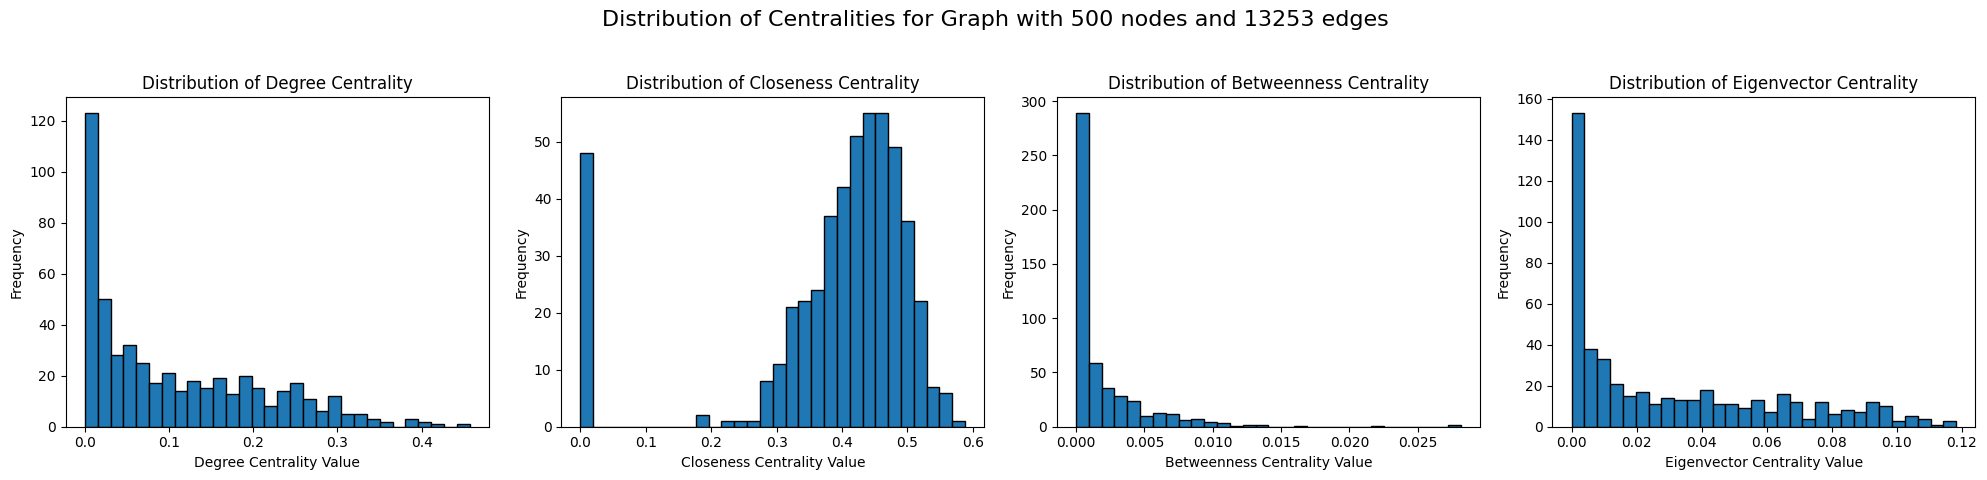

In [41]:
centralities = compute_centralities(recipes_graph)
df = pd.DataFrame(centralities)
plot_centrality_distributions(df, recipes_graph)

## Extra calculations

In [42]:


def compute_correlation(df, col1, col2):
    pearson_corr, _ = pearsonr(df[col1], df[col2])
    spearman_corr, _ = spearmanr(df[col1], df[col2])
    kendall_corr, _ = kendalltau(df[col1], df[col2])
    return pearson_corr, spearman_corr, kendall_corr

def plot_centrality_scatter_plots(df, graph_name):
    centrality_columns = [
        'degree',
        'closeness',
        'betweenness',
        'eigenvector'
    ]
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    axes = axes.flatten()  
    
    plot_index = 0
    for i in range(len(centrality_columns)):
        for j in range(i + 1, len(centrality_columns)):
            col1 = centrality_columns[i]
            col2 = centrality_columns[j]
            
            pearson_corr, spearman_corr, kendall_corr = compute_correlation(df, col1, col2)
            
            axes[plot_index].scatter(df[col1], df[col2], alpha=0.7)
            axes[plot_index].set_title(f'Scatter Plot: {col1} vs {col2}')
            axes[plot_index].set_xlabel(col1)
            axes[plot_index].set_ylabel(col2)
            
            axes[plot_index].text(0.05, 0.95, f'Pearson: {pearson_corr:.2f}\nSpearman: {spearman_corr:.2f}\nKendall: {kendall_corr:.2f}', 
                                   transform=axes[plot_index].transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
            
            plot_index += 1

    plt.tight_layout()
    plt.suptitle(f'Centrality Correlations for {graph_name}', fontsize=16, y=1.02)
    plt.show()


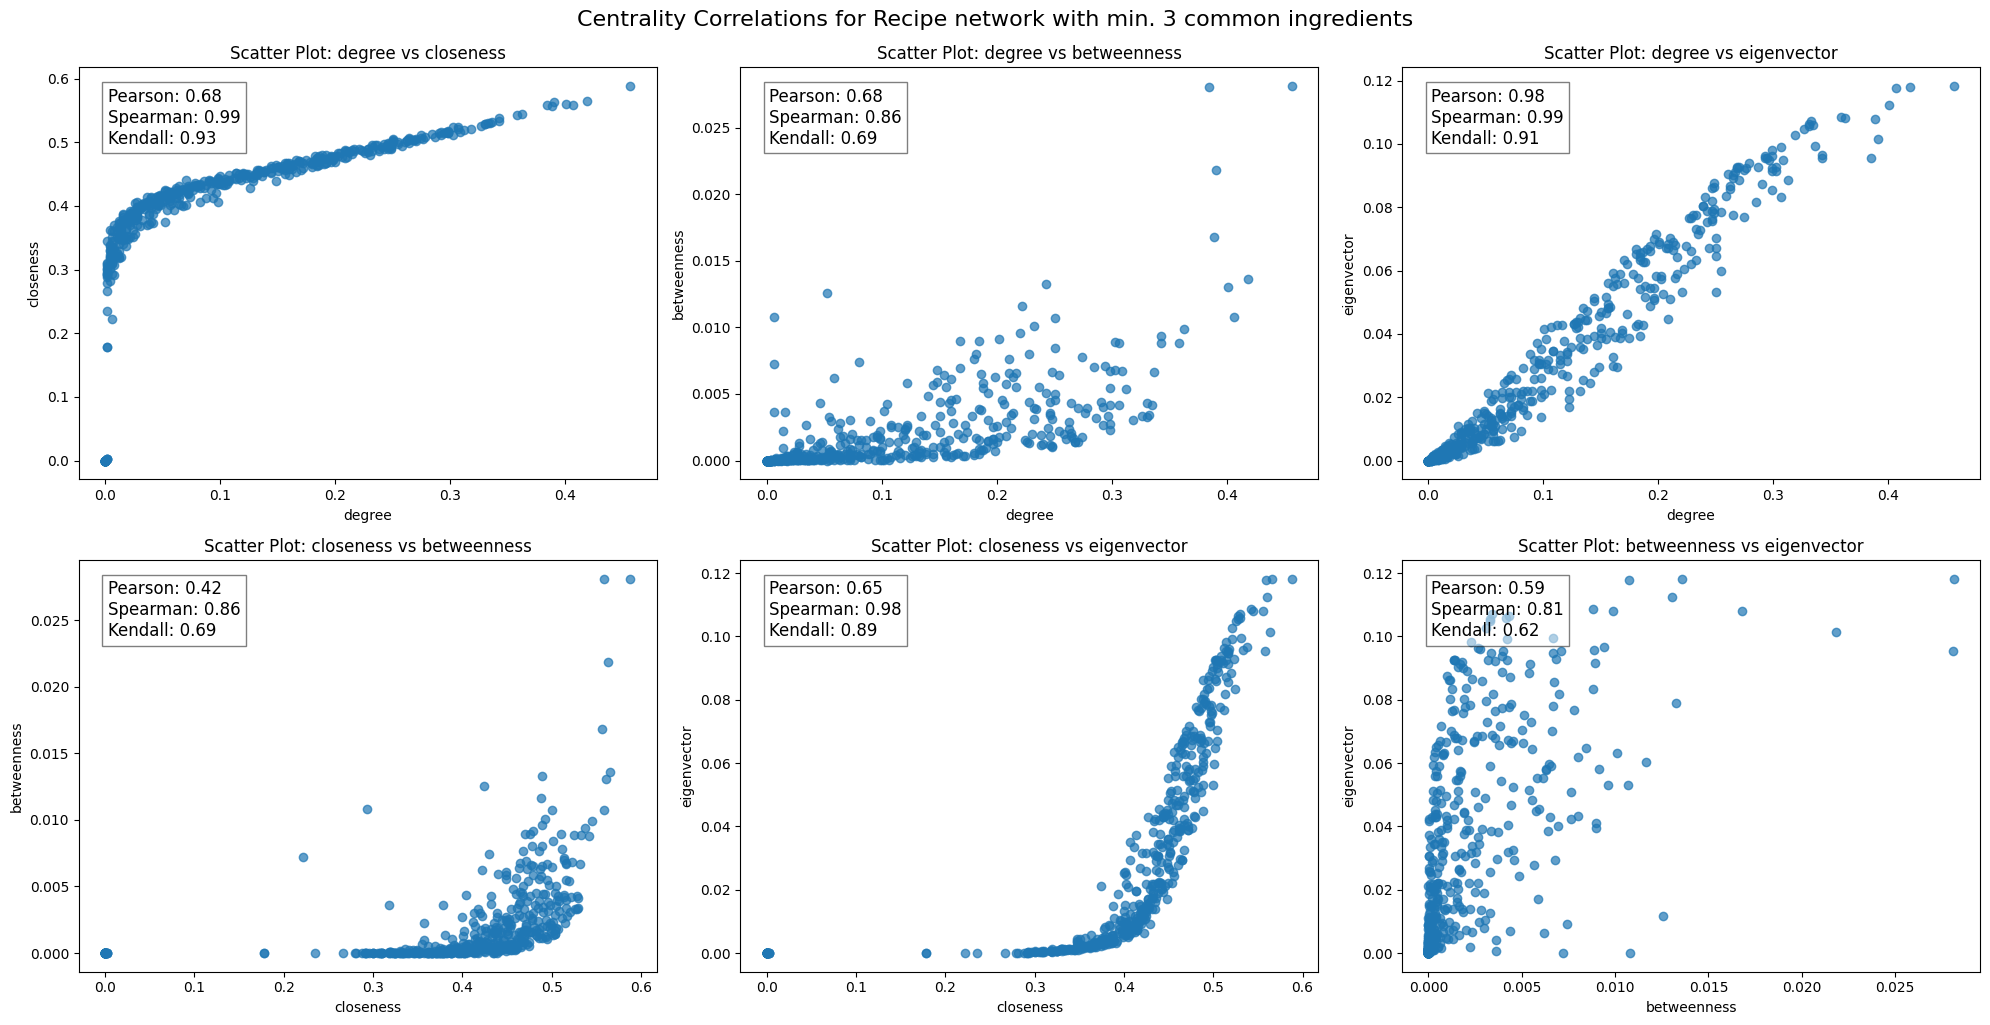

In [ ]:
centralities = compute_centralities(recipes_graph)
df = pd.DataFrame(centralities)
plot_centrality_scatter_plots(df, "Recipe network with min. 6 common ingredients")

In [44]:
def compute_pearson(df1, df2, col):
    return pearsonr(df1[col], df2[col])[0]

def plot_centrality_comparisons(df_original, df_randomized, graph_name):
    centrality_types = ['degree', 'closeness', 'betweenness', 'eigenvector']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()

    for i, centrality in enumerate(centrality_types):
        pearson_corr = compute_pearson(df_original, df_randomized, centrality)
        
        axes[i].scatter(df_original[centrality], df_randomized[centrality], alpha=0.7, label=f'Pearson: {pearson_corr:.2f}')
        axes[i].set_title(f'Original vs Randomized: {centrality.capitalize()}', fontsize=14)
        axes[i].set_xlabel(f'Original {centrality.capitalize()}', fontsize=12)
        axes[i].set_ylabel(f'Randomized {centrality.capitalize()}', fontsize=12)
        axes[i].legend()
    
    plt.tight_layout()
    plt.suptitle(f'Centrality Comparisons: Original vs Randomized ({graph_name})', fontsize=16, y=1.02)
    plt.show()


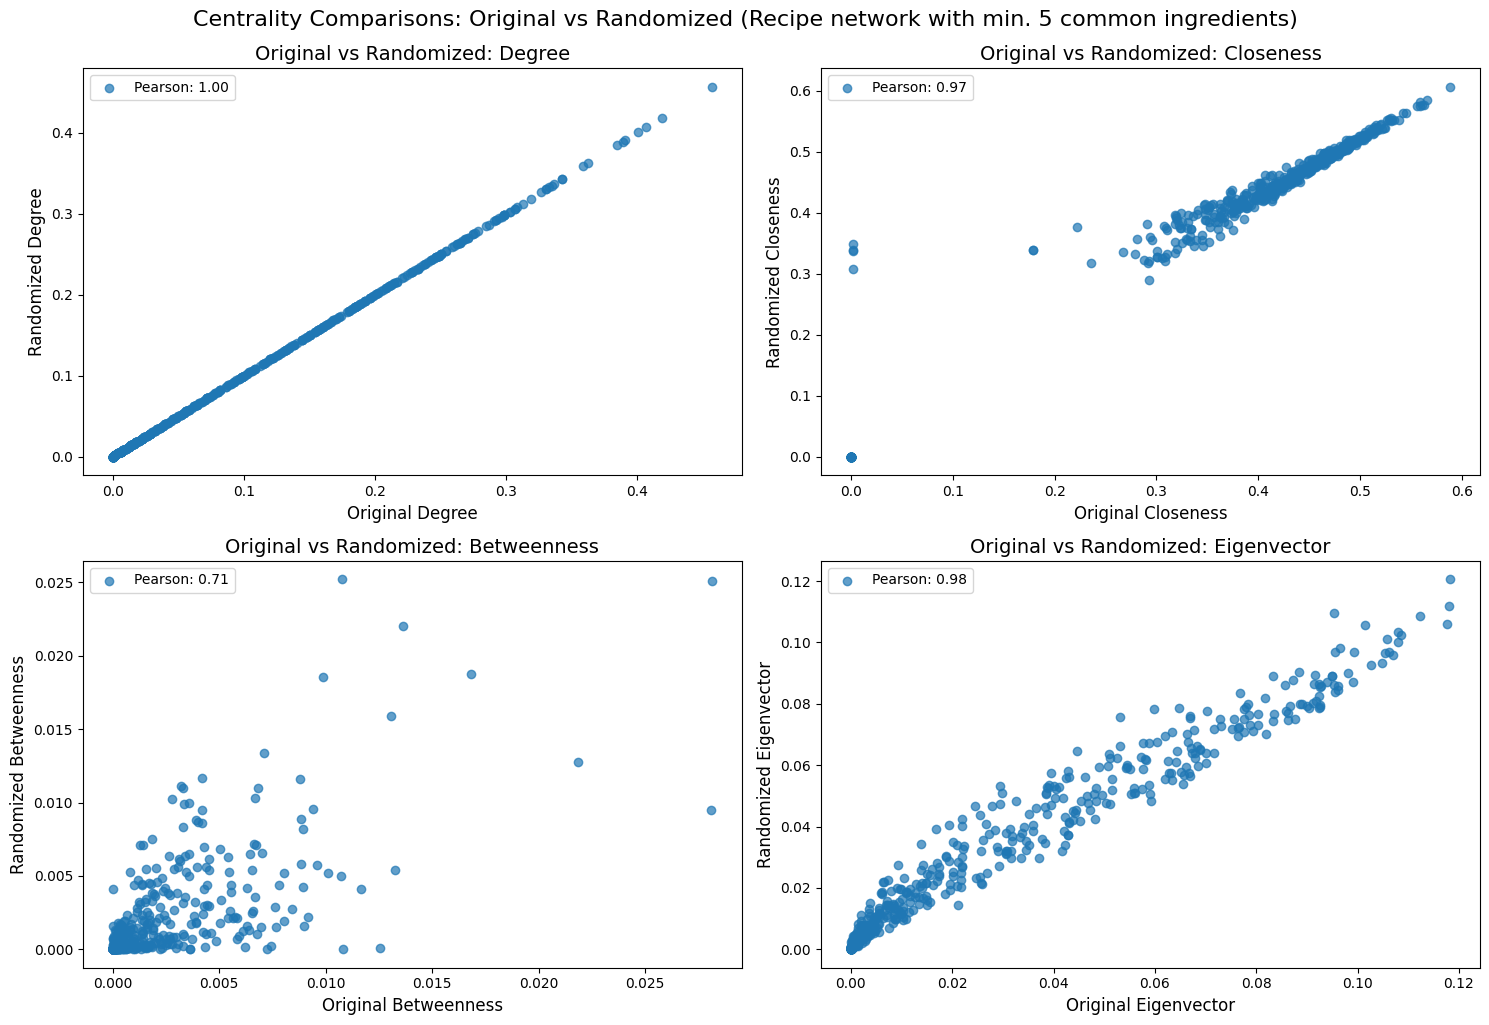

In [ ]:
centralities = compute_centralities(recipes_graph)
df = pd.DataFrame(centralities)
    
randomized_graph = randomize_graph(recipes_graph)
randomized_centralities = compute_centralities(randomized_graph)
df_randomized = pd.DataFrame(randomized_centralities)
    
plot_centrality_comparisons(df, df_randomized, "Recipe network with min. 6 common ingredients")

### Observations

We can see on the plots that the Degree Centrality remains unchanged in the randomized graphs, because the degree distribution is preserved by the randomization. In case of Closeness and Betweenness Centrality we can see a lower correlation because randomization disrupts the shortest-path and flow structures. The Eigenvector Centrality also shows lower correlations but the difference is smaller, depending on how connected the nodes are in the random graph versus the original.

  
#### 1. Degree Centrality
Degree centrality measures the number of direct connections a node has within the network. A recipe with high degree centrality is one that shares a significant number of ingredients with many other recipes. These recipes likely use common ingredients and might represent versatile or foundational recipes that connect to many others.

During the randomization the edges are randomly rewired, but the node degrees remain unchanged, so the degree distribution remains the same, and therefore, the Degree Centrality remains unchanged, as the total number of connections for each node remained constant. Thats why it has 1.0 correlation.

#### 2. Closeness Centrality
Closeness centrality reflects how quickly a node can access other nodes in the network, measured by the average shortest path from that node to all others. A recipe with high closeness centrality can quickly "reach" or is closely connected to other recipes in the network. These recipes might be versatile in the sense that they use a set of ingredients that frequently appear in other recipes, making them central to the graph.

Closeness Centrality shows lower correlation because overall the shortest paths are disrupted because of the randomization.

#### 3. Betweenness Centrality
Betweenness centrality measures the extent to which a node serves as a bridge along the shortest paths between other nodes. Nodes with high betweenness centrality are critical for information flow or connectivity, acting as intermediaries. A recipe with high betweenness centrality acts as a "bridge" between clusters of recipes. These recipes likely share ingredients with multiple distinct groups of recipes and could play a crucial role in connecting different cuisines or cooking styles.

The Betweenness Centrality is also affected by the randomization because when the network is randomized shortest paths are removed or altered, and the nodes that served as intermediaries may no longer fulfill this role. This highlights the sensitivity of betweenness centrality to network structure. 

#### 4. Eigenvector Centrality
Eigenvector centrality evaluates a node's influence based not just on the number of connections but also on the quality and influence of its neighbors. A node connected to other well-connected nodes scores higher. A recipe with high eigenvector centrality is connected to other influential recipes. These recipes are central to the overall structure of the graph and might represent dishes with ingredients that are foundational to many popular or versatile recipes.

With the Eigenvector Centrality the correlation is affected less by the randomization,because it depends on how well the randomization maintains the overall connectivity and flow of importance across nodes. While randomization may disrupt connections, eigenvector centrality continues to reflect the influence of nodes based on their connections to other significant nodes.

#### Observed Differences and Similarities

Degree centrality remained stable in all cases, while closeness, betweenness, and eigenvector centralities were significantly affected by randomization, showcasing how the specific structure of the network influences the sensitivity of different centrality measures.


In [46]:
def plot_fit(G):
    degrees = [degree for _, degree in G.degree()]

    degrees = [d for d in degrees if d > 0]

    if len(degrees) == 0:
        print("No degrees greater than zero in the graph.")
        return

    fit = powerlaw.Fit(degrees, discrete=True)
    alpha = fit.alpha
    xmin = fit.xmin

    alpha_error = fit.sigma

    print(f"Alpha Error: {alpha_error}")
    print(f"Fitted alpha: {alpha}")

    lam = np.mean(degrees)

    hist, bin_edges = np.histogram(
        degrees,
        bins=np.logspace(np.log10(min(degrees)), np.log10(max(degrees)), num=40),
        density=True
    )
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    if np.any(np.isnan(hist)):
        print("Histogram contains NaN values. Check degree distribution.")
        return

    degree_values = np.arange(1, max(degrees) + 1)
    poisson_prob = (lam ** degree_values * np.exp(-lam)) / factorial(degree_values)
    exponential_prob = (1 / lam) * np.exp(-degree_values / lam)

    plt.figure(figsize=(7, 5))

    plt.loglog(bin_centers, hist, 'o', color='blue', markersize=5, label="Empirical Data")
    fit.power_law.plot_pdf(color='red', label=f"Power-Law Fit (α={alpha:.2f})")
    plt.loglog(degree_values, poisson_prob, 'g-', label=f'Poisson Fit (λ = {lam:.2f})')
    plt.loglog(degree_values, exponential_prob, 'm-', label=f'Exponential Fit (λ = {lam:.2f})')

    plt.xlabel("Degree (k)", fontsize=12)
    plt.ylabel("Probability (p(k))", fontsize=12)
    plt.title("Empirical Degree Distribution with Power-Law, Poisson, and Exponential Fits", fontsize=14)
    plt.legend()

    max_empirical_prob = np.nanmax(hist) 
    if max_empirical_prob > 0:
        plt.ylim(1e-6, max_empirical_prob * 1.1)
    else:
        print("Maximum empirical probability is zero or invalid.")
        return

    plt.show()


Calculating best minimal value for power law fit
Alpha Error: 0.569872420330063
Fitted alpha: 5.9022279203960375


C:\Users\vassa\AppData\Local\Temp\ipykernel_1736\3553165567.py:33: RuntimeWarning: overflow encountered in power
  poisson_prob = (lam ** degree_values * np.exp(-lam)) / factorial(degree_values)
C:\Users\vassa\AppData\Local\Temp\ipykernel_1736\3553165567.py:33: RuntimeWarning: invalid value encountered in divide
  poisson_prob = (lam ** degree_values * np.exp(-lam)) / factorial(degree_values)


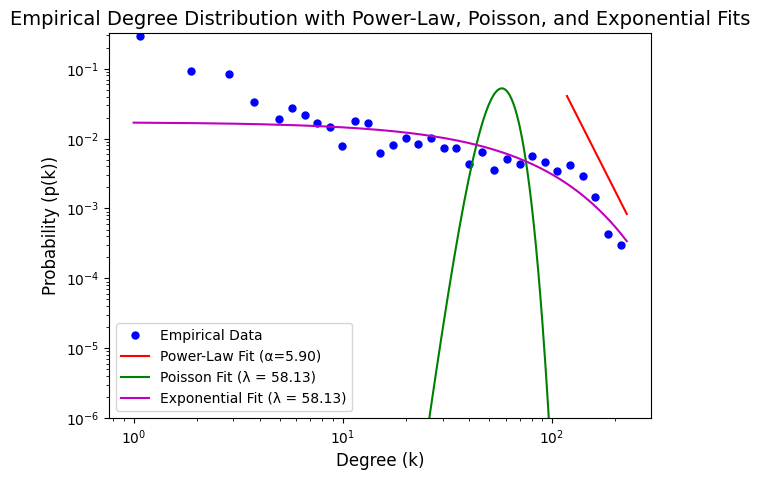

In [47]:
plot_fit(recipes_graph)